# NIRS (model)

In [140]:
import utils as utils
import torch
import numpy as np
import pandas as pd
from icecream import ic
import matplotlib.pyplot as plt
import seaborn as sns

utils.seed_everything(42)

%matplotlib inline
sns.set_style('darkgrid')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Init and reading data

In [141]:
df = pd.read_csv('data/merged_data_processed.csv')
unreviewed_products_df = pd.read_csv('data/unreviewed_products_processed.csv')
products_df = pd.read_csv('data/products_sampled_processed.csv')
reviews_df = pd.read_csv('data/reviews_sampled_processed.csv')

In [142]:
print(f'Shape of df: {df.shape}')
print(f'Shape of unreviewed_products_df: {unreviewed_products_df.shape}')
print(f'Shape of products_df: {products_df.shape}')
print(f'Shape of reviews_df: {reviews_df.shape}')

Shape of df: (47247, 51)
Shape of unreviewed_products_df: (22903, 43)
Shape of products_df: (35246, 43)
Shape of reviews_df: (45477, 9)


In [143]:
print(f'Number of unique products: {products_df["asin"].nunique()}')
print(f'Number of unique users: {reviews_df["reviewerID"].nunique()}')
print(f'Number of unique reviewed products: {df["asin"].nunique()}')
print(f'Number of unique unreviewed products: {unreviewed_products_df["asin"].nunique()}')

Number of unique products: 34211
Number of unique users: 998
Number of unique reviewed products: 11369
Number of unique unreviewed products: 22842


## Other data preparation for the model

### User and product id mapping

In [144]:
# Create user and item mappings
user_mapping = {user_id: index for index, user_id in enumerate(df['reviewerID'].unique())}
item_mapping = {item_id: index for index, item_id in enumerate(products_df['asin'].unique())}

reviewed_item_mapping = {item_id: index for index, item_id in enumerate(df['asin'].unique())}

# Map user and item IDs to indices
df['user_index'] = df['reviewerID'].map(user_mapping)
df['item_index'] = df['asin'].map(reviewed_item_mapping)

### User-item matrix

In [145]:
user_product_matrix = pd.pivot_table(df, values='overall', index='reviewerID', columns='asin', fill_value=0)

### Text Embeddings (with Word2Vec or whatever)

In [146]:
from gensim.models import Word2Vec

# Create embeddings using Word2Vec
def create_word2vec_embeddings(texts, embedding_dim):
  # Tokenize the texts
  tokenized_texts = [text.split() for text in texts]
  
  # Train Word2Vec model
  model = Word2Vec(tokenized_texts, vector_size=embedding_dim, window=5, min_count=1, workers=4)
  
  # Get the embeddings for each text
  embeddings = []
  for text in tokenized_texts:
      embedding = np.mean([model.wv[word] for word in text if word in model.wv], axis=0)
      embeddings.append(embedding)
  
  return np.array(embeddings)

In [147]:
df_reviewed_products = products_df[products_df['asin'].isin(df['asin'].unique())].drop_duplicates(subset=['asin'])
df_reviewed_products['brand'] = df_reviewed_products['brand'].astype(str)
df['brand'] = df['brand'].astype(str)
df_reviewed_products.reset_index(drop=True, inplace=True)

In [148]:
# Create embeddings for textual data
reviewTexts_embs = torch.tensor(create_word2vec_embeddings(df['reviewText'], embedding_dim=200))
summary_embs = torch.tensor(create_word2vec_embeddings(df['summary'], embedding_dim=200))
title_embs = torch.tensor(create_word2vec_embeddings(df_reviewed_products['title'], embedding_dim=200))
description_embs = torch.tensor(create_word2vec_embeddings(df_reviewed_products['description'], embedding_dim=200))
feature_embs = torch.tensor(create_word2vec_embeddings(df_reviewed_products['feature'], embedding_dim=200))
brand_embs = torch.tensor(create_word2vec_embeddings(df_reviewed_products['brand'], embedding_dim=200))

#load the embeddings
# review_embeddings = torch.load('data/embeds/review_embeddings.pt')
# summary_embeddings = torch.load('data/embeds/summary_embeddings.pt')
# description_embeddings = torch.load('data/embeds/description_embeddings.pt')
# title_embeddings = torch.load('data/embeds/title_embeddings.pt')
# feature_embeddings = torch.load('data/embeds/feature_embeddings.pt')

In [149]:
# review (user) embeddings by taking the mean of the review-related embeddings
reviews_text_embs = torch.mean(torch.stack([reviewTexts_embs, summary_embs]), dim=0)

# item embeddings by taking the mean of the item-related embeddings
products_text_embs = torch.mean(torch.stack([title_embs, description_embs, feature_embs, brand_embs]), dim=0)

In [150]:
user_embeddings_map = {}
for i, row in reviews_df.iterrows():
    user_id = row['reviewerID']   
    if user_id not in user_embeddings_map:
        user_embeddings_map[user_id] = [reviews_text_embs[i]]
    else:
        user_embeddings_map[user_id].append(reviews_text_embs[i])

for user_id, emb in user_embeddings_map.items():
    user_tensors = user_embeddings_map[user_id]
    user_embeddings_map[user_id] = torch.mean(torch.stack(user_tensors), dim=0)
    
    
df['user_embs'] = df['reviewerID'].map(user_embeddings_map)

In [151]:
product_embeddings_map = {}
for i, row in df_reviewed_products.iterrows():
    product_id = row['asin']
    product_embeddings_map[product_id] = products_text_embs[i]
    
df['product_embs'] = df['asin'].map(product_embeddings_map)

## Model

### DataLoaders for the Pytorch-based model

In [152]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader 
import numpy as np

# class for the dataset
class AmazonReviewDataset(Dataset):
    def __init__(self, user_ids, product_ids, ratings, users_text_data, products_text_data):
        self.user_ids = user_ids
        self.product_ids = product_ids
        self.ratings = ratings
        self.users_text_data = users_text_data
        self.products_text_data = products_text_data
        
    def __len__(self):
        return len(self.user_ids)

    def __getitem__(self, index):
        user_id = self.user_ids[index]
        item_id = self.product_ids[index]
        rating = self.ratings[index]
        users_text_data = self.users_text_data[index]
        products_text_data = self.products_text_data[index]
        
        return user_id, item_id, rating, users_text_data, products_text_data

# Split the data into train and test sets
train_data, val_data = train_test_split(df, test_size=0.2, random_state=42)


# Create train and test datasets
train_dataset = AmazonReviewDataset(
    train_data['user_index'].values,
    train_data['item_index'].values,
    train_data['overall'].values,
    train_data['user_embs'].values,
    train_data['product_embs'].values

)

test_dataset = AmazonReviewDataset(
    val_data['user_index'].values,
    val_data['item_index'].values,
    val_data['overall'].values,
    val_data['user_embs'].values,
    train_data['product_embs'].values
)

### Quick model test with SVD from scikit-surprise

Quick performance check of SVD by using scikit-surprise:

In [153]:
from surprise import BaselineOnly, Dataset, SVD, Reader, accuracy, Trainset
from surprise.model_selection import cross_validate, train_test_split, KFold

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data_test = Dataset.load_from_df(df[["reviewerID", "asin", "overall"]], reader)

# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data_test, test_size=0.25)

# define a cross-validation iterator
kf = KFold(n_splits=5)

algo = SVD()

for trainset, testset in kf.split(data_test):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

RMSE: 0.7040
RMSE: 0.7224
RMSE: 0.7048
RMSE: 0.7003
RMSE: 0.7127


In [170]:
user_id = 'A1HBTW5M7ZZ9PT'
test_user = reviews_df[reviews_df['reviewerID'] == user_id]
item_id = 'B00006IEI7'

In [171]:
# get a prediction for specific users and items.
pred = algo.predict(user_id, item_id, r_ui=5, verbose=True)

user: A1HBTW5M7ZZ9PT item: B00006IEI7 r_ui = 5.00   est = 4.73   {'was_impossible': False}


### Neural Collaborative Filtering

In [175]:
from torch import nn

class NCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim, text_embedding_users_dims, text_embedding_items_dims, dropout_rate_fc=0.2):
        super(NCF, self).__init__()
        
        # embedding layers for the users and items ids (GMF part)
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        
        # Additional input layers for each type of text embedding
        # (the text embeddings will be passed through an additional 
        # linear layer (text_embedding_layer) to project them into 
        # the same embedding space as the user and item embeddings)
        self.text_embedding_users_layers = nn.Linear(text_embedding_users_dims, embedding_dim)
        self.text_embedding_items_layers = nn.Linear(text_embedding_items_dims, embedding_dim)
            
        # MLP part
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout_rate_fc)
        input_dim = embedding_dim * 2
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate_fc),
            nn.BatchNorm1d(1024),
            
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate_fc),
            nn.BatchNorm1d(256),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate_fc),
            nn.BatchNorm1d(128),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            
            nn.Linear(32, 16),
            nn.ReLU(),
        )
        
        # NeuMF layer (the one after concatenating the GMF
        # output and the MLP output)
        self.output_layer = nn.Linear((embedding_dim) + 16, 1)

    def forward(self, user_ids, item_ids, user_text_embeddings, item_text_embeddings):
        user_embeddings = self.user_embedding(user_ids)
        items_embeddings = self.item_embedding(item_ids)
        
        user_latent = torch.flatten(user_embeddings, start_dim=1)
        item_latent = torch.flatten(items_embeddings, start_dim=1)
        
        user_text_embeddings = self.text_embedding_users_layers(user_text_embeddings)
        item_text_embeddings = self.text_embedding_items_layers(item_text_embeddings)
        
        # MLP part (non-linear)
        gmf_output = torch.multiply(user_latent, item_latent)
        mlp_input = torch.cat([torch.flatten(user_text_embeddings, start_dim=1), torch.flatten(item_text_embeddings, start_dim=1)], dim=1)
        mlp_input = self.dropout(mlp_input)
        mlp_output = self.fc_layers(mlp_input)
                        
        output = self.output_layer(torch.cat([gmf_output, mlp_output], dim=1))
        return output

#### Training and evaluating - related functions

In [176]:
# Train the NCF model
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm
from torch import nn

class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

def train_model(model: NCF, train_data: AmazonReviewDataset, val_data: AmazonReviewDataset, loss_func, optimizer, device, num_epochs):
    train_loss_history = []
    valid_loss_history = []
    
    model.to(device)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    for epoch in range(num_epochs):
        model.train()
        train_loss_sum = 0

        # For each batch
        for user_ids, item_ids, rating, u_text_embeds, p_text_embeds in tqdm(train_data, desc='Training...'):
            user_ids, item_ids, rating = user_ids.to(device), item_ids.to(device), rating.to(device)
            u_text_embeds, p_text_embeds = u_text_embeds.to(device), p_text_embeds.to(device)
            
            optimizer.zero_grad()
            outputs = model(user_ids, item_ids, u_text_embeds, p_text_embeds)
            loss = loss_func(outputs.squeeze(), rating.float())
            loss.backward()
            optimizer.step()
            
            train_loss_sum += loss.item()

        model.eval()
        scheduler.step()
        val_loss, _, _ = predict_and_evaluate(model, val_data, loss_func, device)
                
        # for both training and validation, the actual train loss
        # is the average loss over the entire dataset (the multiple batches)
        train_loss = train_loss_sum / len(train_data)
        train_loss_history.append(train_loss)
        valid_loss_history.append(val_loss)
        
        print(f'Epoch {epoch+1}: train loss = {train_loss:.4f}, val loss = {val_loss:.4f}')
    
    return train_loss_history, valid_loss_history
        
# Evaluate the NCF model
def predict_and_evaluate(model, data, loss_func, device):
    # model.eval()
    predictions = []
    true_ratings = []
    loss = 0.0
    
    with torch.no_grad():
        for user_ids, item_ids, rating, u_text_embeds, p_text_embeds in tqdm(data, desc='Predicting...'):
            user_ids = user_ids.to(device)
            item_ids = item_ids.to(device)
            u_text_embeds = u_text_embeds.to(device)
            p_text_embeds = p_text_embeds.to(device)
            
            outputs = model(user_ids, item_ids, u_text_embeds, p_text_embeds)
            predictions.extend(outputs.squeeze().tolist())
            true_ratings.extend(rating.tolist())
            
            loss += loss_func(outputs.squeeze(), rating.float()).item()

    rmse = np.sqrt(loss / len(data))
    mse = mean_squared_error(true_ratings, predictions)
    mae = mean_absolute_error(true_ratings, predictions)
    return rmse, mse, mae

def plot_accuracy(train_acc_history, val_acc_history, loss_name='RMSE'):
  df = pd.DataFrame({'Epoch': range(1, len(train_acc_history)+1),
             'Train Accuracy': train_acc_history,
             'Validation Accuracy': val_acc_history})

  plt.figure(figsize=(10, 6))
  sns.lineplot(data=df, x='Epoch', y='Train Accuracy', label=f'Train loss ({loss_name})')
  sns.lineplot(data=df, x='Epoch', y='Validation Accuracy', label=f'Validation loss ({loss_name})')
  plt.xlabel('Epoch')
  plt.ylabel(loss_name)
  plt.title(f'Training and Validation loss {loss_name}')
  plt.legend()
  plt.show()

#### Model training

In [177]:
import torch.optim as optim
import torch.nn as nn

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Create the NCF model
num_users = len(user_mapping)
num_items = len(reviewed_item_mapping)
embedding_dim = 200
droput_rate_fc = 0.1
text_embedding_dims = [emb.shape[1] for emb in [reviews_text_embs, products_text_embs]]

model = NCF(
  num_users, num_items, embedding_dim, 200, 200, droput_rate_fc).to(device)

# Define loss function (MSE) and optimizer
loss_func = RMSELoss()
# criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Train the model
num_epochs = 20
print('Loss criterion: RMSE\n')
train_loss_history, val_loss_history =  train_model(model, train_loader, test_loader, loss_func, optimizer, device, num_epochs)

Loss criterion: RMSE



Training...:   4%|▎         | 21/591 [00:00<00:08, 65.01it/s]

Predicting...: 100%|██████████| 148/148 [00:00<00:00, 781.52it/s]


Epoch 1: train loss = 1.1671, val loss = 0.9215


Predicting...: 100%|██████████| 148/148 [00:00<00:00, 719.63it/s]


Epoch 2: train loss = 0.8542, val loss = 0.9253


Predicting...: 100%|██████████| 148/148 [00:00<00:00, 654.87it/s]


Epoch 3: train loss = 0.8265, val loss = 0.9239


Predicting...: 100%|██████████| 148/148 [00:00<00:00, 665.60it/s]


Epoch 4: train loss = 0.7810, val loss = 0.9328


Predicting...: 100%|██████████| 148/148 [00:00<00:00, 499.34it/s]


Epoch 5: train loss = 0.7068, val loss = 0.9415


Predicting...: 100%|██████████| 148/148 [00:00<00:00, 767.51it/s]


Epoch 6: train loss = 0.6193, val loss = 0.9482


Predicting...: 100%|██████████| 148/148 [00:00<00:00, 839.36it/s]


Epoch 7: train loss = 0.6054, val loss = 0.9535


Predicting...: 100%|██████████| 148/148 [00:00<00:00, 812.18it/s]


Epoch 8: train loss = 0.5956, val loss = 0.9567


Predicting...: 100%|██████████| 148/148 [00:00<00:00, 710.55it/s]


Epoch 9: train loss = 0.5845, val loss = 0.9595


Predicting...: 100%|██████████| 148/148 [00:00<00:00, 865.16it/s]


Epoch 10: train loss = 0.5759, val loss = 0.9619


Predicting...: 100%|██████████| 148/148 [00:00<00:00, 440.31it/s]


Epoch 11: train loss = 0.5670, val loss = 0.9608


Predicting...: 100%|██████████| 148/148 [00:00<00:00, 746.30it/s]


Epoch 12: train loss = 0.5660, val loss = 0.9622


Predicting...: 100%|██████████| 148/148 [00:00<00:00, 696.66it/s]


Epoch 13: train loss = 0.5641, val loss = 0.9612


Predicting...: 100%|██████████| 148/148 [00:00<00:00, 434.19it/s]


Epoch 14: train loss = 0.5639, val loss = 0.9616


Predicting...: 100%|██████████| 148/148 [00:00<00:00, 712.60it/s]


Epoch 15: train loss = 0.5616, val loss = 0.9613


Predicting...: 100%|██████████| 148/148 [00:00<00:00, 746.75it/s]


Epoch 16: train loss = 0.5614, val loss = 0.9610


Training...:  30%|██▉       | 176/591 [00:02<00:05, 73.34it/s]


KeyboardInterrupt: 

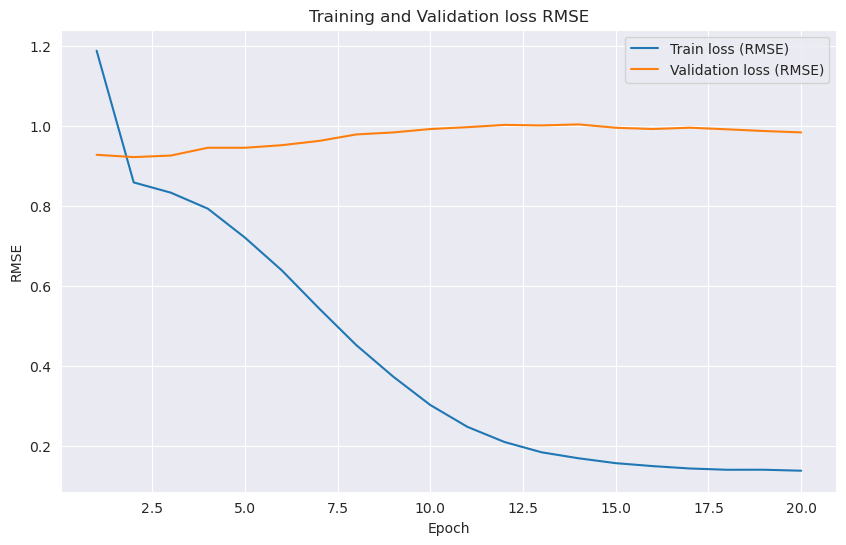

In [ ]:
plot_accuracy(train_loss_history, val_loss_history, 'RMSE')

#### Model test with single predictions

In [ ]:
def predict_score(user_id, item_id, model, user_mapping, item_mapping, device):
    # Convert user ID and item ID to their corresponding indices
    user_index = user_mapping[user_id]
    item_index = item_mapping[item_id]

    # Convert indices to tensors
    user_tensor = torch.tensor([user_index], dtype=torch.long).to(device)
    item_tensor = torch.tensor([item_index], dtype=torch.long).to(device)

    # Get the predicted score from the model
    with torch.no_grad():
        model.eval()
        score = model(user_tensor, item_tensor).item()

    return score

print(f'Predicted rating for user {user_id} and item {item_id}: {predict_score(user_id, 'B0006HXE1E', model, user_mapping, item_mapping, device)}')
# print(f'Actual rating: {user_product_matrix.loc[user_id, item_id]}')

TypeError: NCF.forward() missing 2 required positional arguments: 'user_text_embeddings' and 'item_text_embeddings'

In [ ]:
unreviewed_products_df.head(2)